In [1]:
# Import packages
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [2]:
# Load data
train_data = pd.read_csv('~/Kaggle/SantanderCustomerTransactionPrediction/datasets/train.csv')
test_data = pd.read_csv('~/Kaggle/SantanderCustomerTransactionPrediction/datasets/test.csv')

In [3]:
train_data.head(3)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965


In [78]:
train_data.dtypes

target       int64
var_0      float64
var_1      float64
var_2      float64
var_3      float64
var_4      float64
var_5      float64
var_6      float64
var_7      float64
var_8      float64
var_9      float64
var_10     float64
var_11     float64
var_12     float64
var_13     float64
var_14     float64
var_15     float64
var_16     float64
var_17     float64
var_18     float64
var_19     float64
var_20     float64
var_21     float64
var_22     float64
var_23     float64
var_24     float64
var_25     float64
var_26     float64
var_27     float64
var_28     float64
            ...   
var_170    float64
var_171    float64
var_172    float64
var_173    float64
var_174    float64
var_175    float64
var_176    float64
var_177    float64
var_178    float64
var_179    float64
var_180    float64
var_181    float64
var_182    float64
var_183    float64
var_184    float64
var_185    float64
var_186    float64
var_187    float64
var_188    float64
var_189    float64
var_190    float64
var_191    f

In [4]:
test_data.head(3)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794


In [5]:
# Check the number of registers and features
print("Train shape with Id : {} ".format(train_data.shape))
print("Test shape with Id : {} ".format(test_data.shape))

#Save the 'Id' column
id_name = 'ID_code'
train_ID = train_data[id_name]
test_ID = test_data[id_name]

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train_data.drop(id_name, axis = 1, inplace = True)
test_data.drop(id_name, axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nTrain shape without Id : {} ".format(train_data.shape)) 
print("Test shape without Id : {} ".format(test_data.shape))

Train shape with Id : (200000, 202) 
Test shape with Id : (200000, 201) 

Train shape without Id : (200000, 201) 
Test shape without Id : (200000, 200) 


In [6]:
target = 'target'
source = 'Source'

y_train = train_data[target]
features = train_data.columns.tolist()
features.remove(target)

train_data[source] = 'Train'
test_data[source] = 'Test'

df = pd.concat((train_data, test_data)).reset_index(drop=True)
#df.drop([target], axis = 1, inplace = True)

train_data.drop([source], axis = 1, inplace = True)
test_data.drop([source], axis = 1, inplace = True)

print("df size is : {}".format(df.shape))

#X = df[features]
X = train_data
X_train = train_data[features]
y_train = train_data[target]
y = y_train

df size is : (400000, 202)


In [7]:
df.head(5)

,Source,target,var_0,var_1,var_10,var_100,var_101,var_102,var_103,var_104,...,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99
0,Train,0.0,8.9255,-6.7863,2.9252,9.4763,13.3102,26.5376,1.4403,14.7100,...,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132
1,Train,0.0,11.5006,-4.1473,-0.4032,-13.6950,8.4068,35.4734,1.7093,15.1866,...,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939
2,Train,0.0,8.6093,-2.7457,-0.3249,-0.3939,12.6317,14.8863,1.3854,15.0284,...,-22.4038,7.0883,14.1613,10.5080,14.2621,0.2647,20.4031,17.0360,1.6981,-0.0269
3,Train,0.0,11.0604,-2.1518,2.3061,-19.8592,22.5316,18.6129,1.3512,9.3291,...,-7.5866,7.0364,14.4027,10.7795,7.2887,-1.0930,11.3596,18.1486,2.8344,1.9480
4,Train,0.0,9.8369,-1.4834,-9.4458,-22.9264,12.3562,17.3410,1.6940,7.1179,...,-39.7997,7.0065,9.3627,10.4316,14.0553,0.0213,14.7246,35.2988,1.6844,0.6715


In [8]:
train_data.head(5)

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [9]:
# Descriptive statistics
train_data.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


0: 179902 (89.95%)
1: 20098 (10.05%)


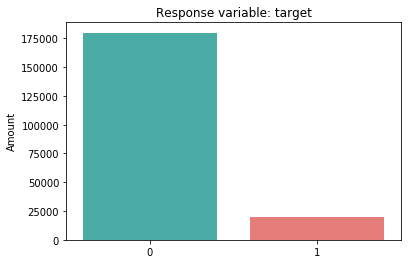

In [10]:
binary_percentage = y.value_counts(normalize=True)*100
binary_count = y.value_counts()
print('0: {} ({}%)'.format(binary_count[0], round(binary_percentage[0],2)))
print('1: {} ({}%)'.format(binary_count[1], round(binary_percentage[1],2)))

labels = ['1' if label == 1 else '0' for label in y]
palette = {'1': '#f56b69', '0': '#3bbbb3'}

ax = sns.countplot(labels, palette=palette)
plt.title('Response variable: target')
plt.ylabel('Amount')
plt.show()

'Target' variable is very unbalanced and corresponds to only 10% of the whole dataset. Thus it will require a correction prior to creating the model.

In [71]:
# Assign the dataframe you want to evaluate
temp_df = df

df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
missing_data = pd.DataFrame({'Missing n':temp_df.isnull().sum(),'% Missing' :df_nan})
missing_data.sort_values('% Missing', ascending=False).head(5)

,% Missing,Missing n
target,50.0,200000
var_42,0.0,0
var_33,0.0,0
var_34,0.0,0
var_35,0.0,0


There are no missing values in the dataset, apart from the target variable provenient from the test set, which is coherent. Thus it seems everything is ok in this matter.

In [74]:
# Assign the dataframe you want to evaluate
temp_df = df

n_total = len(temp_df['target'])
idcol = []
counter = []
zeros_data = []
features = temp_df.columns
features = [c for c in temp_df.columns if c not in [ ['target', 'Source']]


for col in features:
    zeros_count = n_total - np.count_nonzero(temp_df[col])
    idcol.append(col)
    counter.append(zeros_count)
    zeros_data.append(zeros_count / n_total * 100)
zeros_data = pd.DataFrame({'Zero amount': counter,'% Zero' : zeros_data})
zeros_data.index = idcol
zeros_data.sort_values('% Zero', ascending = False).head(5) 

,% Zero,Zero amount
target,44.97550,179902
var_95,0.00650,26
var_131,0.00625,25
var_27,0.00275,11
var_39,0.00250,10


There are no columns where the amount of zeros are expressive, except from the target variable which is indeed a binary variable with 0 and 1.
It seems everything is ok in this matter.

In [86]:
# Summarize the unique values
df.nunique().sort_values().head(10)

Source         2
target         2
var_68       461
var_91      8197
var_108     8651
var_103     9634
var_12      9737
var_148    10894
var_161    11359
var_71     13968
dtype: int64

In [87]:
train_data.nunique().sort_values().head(10)

target         2
var_68       451
var_91      7962
var_108     8525
var_103     9376
var_12      9561
var_148    10608
var_161    11071
var_71     13527
var_25     14853
dtype: int64

In [88]:
test_data.nunique().sort_values().head(10)

var_68       428
var_91      7569
var_108     8188
var_103     8828
var_12      9121
var_148     9964
var_161    10506
var_71     12604
var_25     13728
var_43     14288
dtype: int64

I just wanted to check that all variables are really continuous and not categorical. I might take a closer look at 'var_68', other than that, the dataset seems coherent.

In [93]:
train_data['var_68'].describe()
train_data['var_91'].describe()

count    200000.000000
mean          6.987541
std           0.152641
min           6.521800
25%           6.869900
50%           6.986500
75%           7.101400
max           7.489500
Name: var_91, dtype: float64

In [75]:
# Descriptive statistics, summarized by the output variable
# Needs improvement
train_data.groupby('target').describe()

var_0                                                              \
           count       mean       std     min       25%       50%        75%   
target                                                                         
0       179902.0  10.626681  3.008564  0.4084  8.429500  10.47860  12.693075   
1        20098.0  11.156418  3.270293  0.4528  8.695875  11.00135  13.343700   

                    var_1             ...      var_98            var_99  \
            max     count      mean   ...         75%     max     count   
target                                ...                                 
0       20.3150  179902.0 -1.695770   ...    2.260775  4.5028  179902.0   
1       19.4583   20098.0 -1.017613   ...    2.263100  4.2221   20098.0   

                                                                        
            mean       std     min       25%      50%      75%     max  
target                                                                  
0      -0.782632  1.843534 -7.2806 -2.126200 -0.80675  0.48530  5.0764  
1      -0.421047  1.995618 -7.1508 -1.897575 -0.39600  0.93475  4.9939  

[2 rows x 1600 columns]

# Obtain an overview of the variables
import pandas_profiling as pf
pf.ProfileReport(df)

from collections import Counter
# Outlier detection 
def detect_outliers(df,n,features):
    outlier_indices = []
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col],25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index       
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than n outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v >= n )
    return multiple_outliers   

# Identify and list the outliers that should be potentially dropped
drop_outliers = detect_outliers(train_data,2, features)
print("The dataset contains", len(drop_outliers),"outliers")
train_data.loc[drop_outliers]

# Removing outliers
Q1 = train_data.quantile(0.25)
Q3 = train_data.quantile(0.75)
IQR = Q3 - Q1
print('IQR das variáveis:\n')
print(IQR)

print()
print('Dimensões do dataset com outliers:', train_data.shape)

train_data = train_data[~((train_data < (Q1 - 1.5 * IQR)) |(train_data > (Q3 + 1.5 * IQR))).any(axis=1)]
X = train_data[features]
y = train_data[target]

print('Dimensões do dataset sem outliers:', train_data.shape)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.3, random_state=42)

#X_train = X
#y_train = y

In [ ]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer, Binarizer, KernelCenterer, MaxAbsScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

pipelines = []

#for clf in [
#    LogisticRegression(),
#    SVC(kernel='linear'),
#    KNeighborsClassifier(),
#    RandomForestClassifier(),
#    XGBClassifier(),
#    GaussianNB(),
#    MLPClassifier(),
#    AdaBoostClassifier(),
#    GradientBoostingClassifier()
#]:
for clf in [
    LogisticRegression()]:
   
    
    for normalizer in [
        None,
        Normalizer()
    ]:
        clf_pipeline = make_pipeline(normalizer, clf)
        
        pipelines.append({
            'Algorithm': clf.__class__.__name__,
            'Normalizer': normalizer.__class__.__name__,
            'AUC': cross_val_score(clf_pipeline, X_train, y_train, cv=10,scoring='roc_auc')
        })
        
pd.DataFrame(pipelines).sort_values(by='AUC', ascending=False)

In [ ]:
pipeline = Pipeline([
    ('normalizer',MinMaxScaler()),
    ('classifier', MLPClassifier()),
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(test_data[features]) # check 'features'

submission = test_data[['id']]
submission['classe'] = predictions
submission.to_csv('submission.csv', index=False)

In [ ]:
# Import do módulo
from sklearn.linear_model import LogisticRegression


# Criando o obketo logistic regression 
modelo = LogisticRegression()

# Treinando o modelo com dados de treino e checando o score
modelo.fit(X_train, y_train)
modelo.score(X_train, y_train)

# Coletando os coeficientes
print('Coefficient: \n', modelo.coef_)
print('Intercept: \n', modelo.intercept_)

# Previsões
valores_previstos = modelo.predict(X_test)


In [ ]:
from sklearn import model_selection

# Definindo os valores para os folds
num_folds = 10
num_instances = len(X_train)
seed = 7

# Separando os dados em folds
kfold = model_selection.KFold(num_folds, True, random_state = seed)

# Criando o modelo
modelo = LogisticRegression()
resultado = model_selection.cross_val_score(modelo, X_train, y_train, cv = kfold, scoring='roc_auc')

# Usamos a média e o desvio padrão
print("Acurácia: %.3f%% (%.3f%%)" % (resultado.mean()*100.0, resultado.std() * 100.0))

In [ ]:
# Score
result = modelo.score(X_train, y_train)
print("Acurácia: %.3f%%" % (result * 100.0))

In [ ]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.33,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.04,
    'learning_rate': 0.008,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': 1
}

In [ ]:
num_round = 1000000
# check random state 44000
folds = StratifiedKFold(n_splits=12, shuffle=False, random_state=12345)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

In [ ]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3500)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

In [ ]:
submission = pd.DataFrame({"ID_code": test_df.ID_code.values})
submission["target"] = predictions
submission.to_csv("submission.csv", index=False)

In [ ]:
submission.head()